In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
import pandas as pd
import numpy as np

import gc

In [42]:
def question_2_correlation():
    """
    Question 2: Calculate correlations between intraday, overnight, and regular momentum
    """
    print("\nQuestion 2: Momentum Correlations")
    print("=" * 50)

    df = pd.read_parquet('/content/drive/MyDrive/data_for_7037/hw2_mfin7037_data.parquet')
    momentum_cols = ['mom_intraday', 'mom_overnight', 'mom']
    corr_matrix = df[momentum_cols].corr()

    print("\nBenchmark Data Range:")
    print(f"Start Date: {df['date'].min()}")
    print(f"End Date: {df['date'].max()}")

    print("\nCorrelation Matrix:")
    print(corr_matrix)
    return df

In [7]:
import pandas as pd
momentum_columns = ['mom_intraday', 'mom', 'mom_overnight']
correlation_matrix = df[momentum_columns].corr()
print(correlation_matrix)

               mom_intraday       mom  mom_overnight
mom_intraday       1.000000  0.591998      -0.691953
mom                0.591998  1.000000       0.105443
mom_overnight     -0.691953  0.105443       1.000000


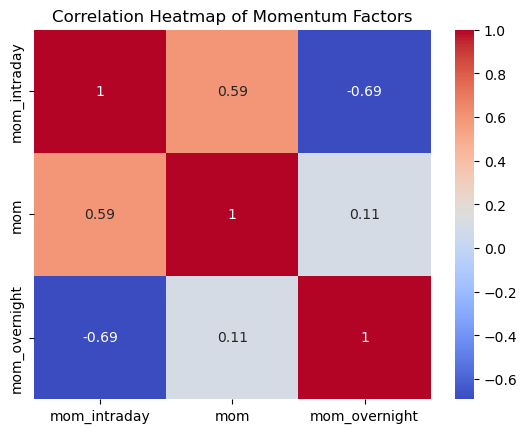

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
correlation_matrix = np.array([[1.000000, 0.591998, -0.691953],
                               [0.591998, 1.000000, 0.105443],
                               [-0.691953, 0.105443, 1.000000]])
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", xticklabels=["mom_intraday", "mom", "mom_overnight"], yticklabels=["mom_intraday", "mom", "mom_overnight"])
plt.title('Correlation Heatmap of Momentum Factors')
plt.show()

In [43]:
def calculate_tesla_momentum():
    """
    Question 3: Calculate Tesla momentum using CRSP DSF
    """
    print("\nQuestion 3: Tesla Momentum Calculation")
    print("=" * 50)

    # Get benchmark timeframe
    benchmark_start, benchmark_end = get_benchmark_timeframe()
    print(f"\nBenchmark Period: {benchmark_start} to {benchmark_end}")

    # Load and process Tesla data
    tesla_data = pd.read_parquet(
        '/content/drive/MyDrive/data_for_7037/crsp_202401.dsf.parquet',
        filters=[('permno', '=', 93436)],
        columns=['date', 'permno', 'prc', 'openprc']
    )

    tesla_data['date'] = pd.to_datetime(tesla_data['date'])
    tesla_data = tesla_data.sort_values('date')

    # Filter to match benchmark timeframe
    tesla_data = tesla_data[
        (tesla_data['date'] >= benchmark_start) &
        (tesla_data['date'] <= benchmark_end)
    ]

    # Calculate returns
    tesla_data['intraday_ret'] = tesla_data['prc'].abs() / tesla_data['openprc'] - 1
    tesla_data['overnight_ret'] = tesla_data['openprc'] / tesla_data['prc'].shift(1).abs() - 1

    # Convert to monthly data
    monthly_data = tesla_data.set_index('date').resample('ME').agg({
        'prc': 'last',
        'intraday_ret': lambda x: np.sum(np.log1p(x)),
        'overnight_ret': lambda x: np.sum(np.log1p(x))
    }).reset_index()

    # Calculate momentum
    monthly_data['mom_intraday'] = monthly_data['intraday_ret'].rolling(window=5, min_periods=5).sum().shift(2)
    monthly_data['mom_overnight'] = monthly_data['overnight_ret'].rolling(window=5, min_periods=5).sum().shift(2)

    print("\nLast 5 Months of Calculated Data:")
    print(monthly_data.tail()[['date', 'prc', 'mom_intraday', 'mom_overnight']])

    return monthly_data


In [44]:
def verify_calculations():
    """
    Verify calculations against benchmark data
    """
    # Get benchmark data
    benchmark_df = question_2_correlation()
    benchmark_tesla = benchmark_df[benchmark_df['permno'] == 93436].copy()

    # Get calculated data
    calculated_df = calculate_tesla_momentum()

    # Get the last month for comparison
    benchmark_last = benchmark_tesla.iloc[-1]
    calculated_last = calculated_df.iloc[-1]

    print("\nVerification of End-of-Sample Values:")
    print(f"Date: {calculated_last['date'].strftime('%Y-%m-%d')}")

    print("\nIntraday Momentum:")
    print(f"Benchmark: {benchmark_last['mom_intraday']:.6f}")
    print(f"Calculated: {calculated_last['mom_intraday']:.6f}")
    print(f"Difference: {(calculated_last['mom_intraday'] - benchmark_last['mom_intraday']):.6f}")

    print("\nOvernight Momentum:")
    print(f"Benchmark: {benchmark_last['mom_overnight']:.6f}")
    print(f"Calculated: {calculated_last['mom_overnight']:.6f}")
    print(f"Difference: {(calculated_last['mom_overnight'] - benchmark_last['mom_overnight']):.6f}")


In [46]:
def main():
    drive.mount('/content/drive')
    verify_calculations()

if __name__ == "__main__":
    main()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Question 2: Momentum Correlations

Benchmark Data Range:
Start Date: 1925-12-31
End Date: 2022-09-30

Correlation Matrix:
               mom_intraday  mom_overnight       mom
mom_intraday       1.000000      -0.655101  0.576277
mom_overnight     -0.655101       1.000000  0.134288
mom                0.576277       0.134288  1.000000

Question 3: Tesla Momentum Calculation

Benchmark Period: 2010-06-30 to 2022-09-30

Last 5 Months of Calculated Data:
          date        prc  mom_intraday  mom_overnight
143 2022-05-31  758.26001     -0.099856       0.066635
144 2022-06-30  673.41998     -0.444147       0.170563
145 2022-07-31  891.45001     -0.471132       0.139177
146 2022-08-31  275.60999     -0.332035       0.002020
147 2022-09-30  265.25000     -0.160534       0.184396

Verification of End-of-Sample Values:
Date: 2022-09-30

Intraday Momentum:
Benchmark: 

In [4]:
def check_tesla_data():
    """
    Only examine Tesla data from CRSP DSF
    """
    # Mount Google Drive
    drive.mount('/content/drive')

    # Load only Tesla data with minimal columns
    columns_needed = ['date', 'permno', 'prc', 'openprc']
    tesla_data = pd.read_parquet(
        '/content/drive/MyDrive/data_for_7037/crsp_202401.dsf.parquet',
        filters=[('permno', '=', 93436)],
        columns=columns_needed
    )

    print("\nTesla Data Sample:")
    print("=" * 50)
    print("\nFirst 5 rows:")
    print(tesla_data.head())

    print("\nData Info:")
    print(tesla_data.info())

    print("\nDate Range:")
    print(f"Start: {tesla_data['date'].min()}")
    print(f"End: {tesla_data['date'].max()}")

    print("\nMissing Values:")
    print(tesla_data.isnull().sum())

if __name__ == "__main__":
    check_tesla_data()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Tesla Data Sample:

First 5 rows:
         date  permno    prc  openprc
0  2010-06-29   93436  23.89    19.00
1  2010-06-30   93436  23.83    25.79
2  2010-07-01   93436  21.96    25.00
3  2010-07-02   93436  19.20    23.00
4  2010-07-06   93436  16.11    20.00

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3400 entries, 0 to 3399
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     3400 non-null   object 
 1   permno   3400 non-null   int32  
 2   prc      3400 non-null   float64
 3   openprc  3400 non-null   float64
dtypes: float64(2), int32(1), object(1)
memory usage: 93.1+ KB
None

Date Range:
Start: 2010-06-29
End: 2023-12-29

Missing Values:
date       0
permno     0
prc        0
openprc    0
dtype: int64


In [ ]:
### Q4:Now report the 12 row x 11 column table, where the 
### columns are the average returns/t-staSsScs of those returns for porholios 1..10 and 
### then the long-short porholio, and there are six sets of rows, one for EW, VW, EW 
### overnight, VW overnight, EW intraday, EW overnight.

In [1]:
# install fastparquet via system call
!pip3 install fastparquet
!pip3 install statsmodels 
!pip3 install matplotlib
import fastparquet 
import pandas as pd, os
import numpy as np

In [5]:
# set worknig directory to be wherever your data is
try: 
    os.chdir('/Volumes/evo/Dropbox (Personal)/teaching_2025_scratch')
except:
    print("need to point to the rigth directory")
df = pd.read_parquet('E:/data/7037/hw2_mfin7037_data.parquet')
df = df.query("date>='1994-01-01'")
df.head()

need to point to the rigth directory


,permno,date,ret,intraday_ret_month,overnight_ret_month,mcap_lag1,prc_lag1,mom_intraday,mom,mom_overnight,mcap_bin
148,10094.0,1994-01-31,0.181818,-0.234356,0.543560,42515.000,5.500,-0.307430,-0.087011,0.229986,4.0
149,10094.0,1994-02-28,-0.115385,0.222005,-0.276094,50245.000,6.500,-0.923227,-0.646627,0.286166,5.0
150,10094.0,1994-03-31,-0.152174,0.187957,-0.286318,44447.500,5.750,-1.428256,-0.712195,0.725624,4.0
151,10094.0,1994-04-29,-0.076923,0.236076,-0.253220,37756.875,4.875,-1.398879,-0.834798,0.564079,4.0
152,10094.0,1994-05-31,0.027778,-0.138717,0.193312,34852.500,4.500,-0.764079,-0.640503,0.123572,4.0


In [11]:
df['prc'] = df['prc_lag1'].shift(-1)
data = df
df = df[(df['mcap_bin'] > 2) & (df['prc'] >= 5)]

In [13]:
def produce_table(input_data, subsetting=lambda df: df):
    """
    Combines portfolio data from 'bins' and 'pnl', computes summary statistics
    (mean returns multiplied by 100 and one-sample t-test statistics) for each portfolio,
    and returns a pivoted table for portfolios 1..10 and a long-short portfolio.
    
    Parameters:
        input_data (dict): Dictionary with keys:
            - 'bins': a DataFrame with columns ['date','bin','ew','vw',
                      'ew_intraday','vw_intraday','ew_overnight','vw_overnight']
            - 'pnl': a DataFrame with columns ['date','ew','vw',
                      'ew_intraday','vw_intraday','ew_overnight','vw_overnight']
                      (this will be used to compute the long-short portfolio)
        subsetting (function): A function to subset/modify the combined DataFrame.
                               Defaults to the identity function.
    
    Returns:
        pd.DataFrame: A table where each row corresponds to a return measure (e.g., EW, VW, etc.)
                      with the first row showing the mean (×100, rounded to 3 decimals) and the second
                      row showing the t-statistic (in parentheses). The long-short portfolio is labeled "10-1".
    """
    # Extract the required columns from each DataFrame.
    bins_df = input_data['bins'][['date', 'bin', 'ew', 'vw', 
                                  'ew_intraday', 'vw_intraday', 
                                  'ew_overnight', 'vw_overnight']].copy()
    pnl_df = input_data['pnl'][['date', 'ew', 'vw', 
                                'ew_intraday', 'vw_intraday', 
                                'ew_overnight', 'vw_overnight']].copy()
    # Designate the pnl data as portfolio "11" (which later will be renamed to "10-1")
    pnl_df['bin'] = 11

    # Combine the two datasets and apply any subsetting
    combined = pd.concat([bins_df, pnl_df], ignore_index=True)
    combined = subsetting(combined)

    # List of return measure columns
    cols = ['ew', 'vw', 'ew_intraday', 'vw_intraday', 'ew_overnight', 'vw_overnight']

    # Function to compute mean multiplied by 100 and rounded to 3 decimals
    def meanna(x):
        return round(x.mean() * 100, 3)

    # Compute group-wise means by portfolio (bin)
    s1 = combined.groupby('bin')[cols].agg(meanna).reset_index()
    s1_melt = s1.melt(id_vars='bin', var_name='variable', value_name='value')
    s1_pivot = s1_melt.pivot(index='variable', columns='bin', values='value').reset_index()
    s1_pivot['order'] = 1

    # Function to compute one-sample t-test statistic (null: mean=0), rounded to 3 decimals and wrapped in parentheses.
    def ttesting(x):
        x = x.dropna()
        if len(x) == 0:
            return None
        stat, _ = ttest_1samp(x, popmean=0)
        return f"({round(stat, 3)})"

    # Compute group-wise t-statistics by portfolio (bin)
    s2 = combined.groupby('bin')[cols].agg(ttesting).reset_index()
    s2_melt = s2.melt(id_vars='bin', var_name='variable', value_name='value')
    s2_pivot = s2_melt.pivot(index='variable', columns='bin', values='value').reset_index()
    s2_pivot['order'] = 2

    # Combine the mean and t-statistic tables
    table = pd.concat([s1_pivot, s2_pivot], ignore_index=True)
    table = table.sort_values(by=['variable', 'order'])
    # For rows with t-statistics (order 2), clear the 'variable' name
    table.loc[table['order'] == 2, 'variable'] = ''
    table = table.drop(columns=['order'])

    # Format the variable names: uppercase and replace underscores with spaces
    table['variable'] = table['variable'].str.upper().str.replace('_', ' ', regex=False)
    table = table.rename(columns={'variable': 'Portfolio'})

    # Rename portfolio 11 to "10-1" (i.e. the long-short portfolio)
    if 11 in table.columns:
        table = table.rename(columns={11: '10-1'})
    
    # Ensure that only portfolios 1 through 10 and the long-short ("10-1") remain.
    valid_portfolios = list(range(1, 11)) + ['10-1']
    cols_to_keep = ['Portfolio'] + [col for col in table.columns if col in valid_portfolios]
    table = table[cols_to_keep]

    return table


# --- Helper: Apply quantiles within each date group ---
def apply_quantiles(df, col, bins=10):
    """
    Assigns a quantile-based bin (1,...,bins) for each value in `col`
    within each date group.
    """
    def quantile_bin(s):
        # Use pd.qcut to get quantile bins; if duplicate edges occur, use rank instead.
        try:
            return pd.qcut(s, q=bins, labels=False, duplicates="drop") + 1
        except Exception:
            return np.ceil(s.rank(method='average') / len(s) * bins)
    return df.groupby('date')[col].transform(quantile_bin)


In [15]:

import matplotlib.pyplot as plt

from scipy.stats import ttest_1samp
import statsmodels.formula.api as smf


def routine_pnl(dta, plot=False):
    """
    Computes portfolio returns (EW/VW) by bin, optionally creates two plots 
    (mean returns by bin and cumulative pnl), runs a series of OLS regressions, 
    and returns a dictionary with outputs.
    
    Assumes dta contains columns: date, bin, ret, mcap_lag1, 
    intraday_ret_month, overnight_ret_month.
    
    Parameters:
      dta   : pd.DataFrame
              Input data.
      plot  : bool, default False
              If True, plots are created; if False, they are suppressed.
    
    Returns:
      dict with keys:
          'p1'             : Axes for decile plot (or None if plot==False)
          'pnl_curve'      : Axes for cumulative pnl plot (or None if plot==False)
          'factor_loadings': Dictionary of regression results
          'pnl'            : DataFrame of pnl calculations
          'bins'           : DataFrame of computed bin returns
    """
    # Ensure date is datetime
    dta = dta.copy()
    dta['date'] = pd.to_datetime(dta['date'])
    
    # Helper: Weighted mean
    def weighted_mean(x, w):
        return np.average(x, weights=w)
    
    # Compute portfolio returns by date and bin
    bins = (dta.groupby(['date', 'bin'])
            .apply(lambda g: pd.Series({
                'ew': g['ret'].mean(),
                'vw': weighted_mean(g['ret'], g['mcap_lag1']),
                'ew_intraday': g['intraday_ret_month'].mean() if 'intraday_ret_month' in g.columns else np.nan,
                'vw_intraday': weighted_mean(g['intraday_ret_month'], g['mcap_lag1']) if 'intraday_ret_month' in g.columns else np.nan,
                'ew_overnight': g['overnight_ret_month'].mean() if 'overnight_ret_month' in g.columns else np.nan,
                'vw_overnight': weighted_mean(g['overnight_ret_month'], g['mcap_lag1']) if 'overnight_ret_month' in g.columns else np.nan,
            }))
            .reset_index())
    
    # Create decile plot (collapsed across dates) if plotting is requested
    if plot:
        bins_collapsed = bins.groupby('bin')[['ew','vw']].mean().reset_index()
        fig1, ax1 = plt.subplots()
        ax1.plot(bins_collapsed['bin'], bins_collapsed['ew'], label='EW', marker='')
        ax1.plot(bins_collapsed['bin'], bins_collapsed['vw'], label='VW', marker='')
        ax1.set_xlabel('Bin')
        ax1.set_ylabel('Return')
        ax1.set_title('Mean Portfolio Returns by Bin')
        ax1.legend()
        plt.tight_layout()
    else:
        ax1 = None
    
    # Compute long-short pnl using the extreme bins (assume bin 1 and max(bin))
    max_bin = bins['bin'].max()
    selected = bins[bins['bin'].isin([1, max_bin])].copy()
    selected['weight'] = selected['bin'].apply(lambda x: -1 if x == 1 else 1)
    pnl = (selected.groupby('date')
           .apply(lambda g: pd.Series({
               'ew': (g['weight'] * g['ew']).sum(),
               'vw': (g['weight'] * g['vw']).sum(),
               'ew_intraday': (g['weight'] * g['ew_intraday']).sum() if 'ew_intraday' in g.columns else np.nan,
               'vw_intraday': (g['weight'] * g['vw_intraday']).sum() if 'vw_intraday' in g.columns else np.nan,
               'ew_overnight': (g['weight'] * g['ew_overnight']).sum() if 'ew_overnight' in g.columns else np.nan,
               'vw_overnight': (g['weight'] * g['vw_overnight']).sum() if 'vw_overnight' in g.columns else np.nan,
           })).reset_index())
    pnl = pnl.sort_values('date')
    pnl['cumvw'] = (1 + pnl['vw']).cumprod() - 1
    pnl['cumew'] = (1 + pnl['ew']).cumprod() - 1
    
    # Create cumulative pnl plot if plotting is requested
    if plot:
        fig2, ax2 = plt.subplots()
        ax2.plot(pnl['date'], pnl['cumew'], label='EW')
        ax2.plot(pnl['date'], pnl['cumvw'], label='VW')
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Cumulative Return')
        ax2.set_title('Cumulative PnL Over Time')
        ax2.legend()
        plt.tight_layout()
    else:
        ax2 = None
    
    # Minimal regressions for demonstration, not done tho
    formulas = [
        'ew ~ 1',
        'vw ~ 1',
        'ew ~ 0',  # dummy formula if needed
    ]
    regs = {}
    for bin_val in sorted(bins['bin'].unique()):
        data_bin = bins[bins['bin'] == bin_val]
        for fml in formulas:
            key = f'bin {bin_val} fml {fml}'
            try:
                model = smf.ols(formula=fml, data=data_bin).fit()
            except Exception as e:
                model = None
                print(f"Regression failed for bin {bin_val} with formula '{fml}': {e}")
            regs[key] = model
            
    # Return outputs in a dictionary
    return {
        'p1': ax1,                # decile plot (or None)
        'pnl_curve': ax2,         # cumulative pnl plot (or None)
        'factor_loadings': regs,  # regression results
        'pnl': pnl,               # pnl table
        'bins': bins              # bins table (with computed returns)
    }

In [17]:
# --- Strategy 1 ---
# (Following the R code, first a ranking step is done then overwritten by quantiles on mom_intraday)
res2_strategy1 = df.copy()
# Here we assign bin using mom_intraday quantiles (10 bins)
res2_strategy1['bin'] = apply_quantiles(res2_strategy1, 'mom_overnight', bins=10)
subset1 = res2_strategy1.dropna(subset=['bin', 'mcap_lag1', 'ret'])
strat1 = routine_pnl(subset1)
table1 = produce_table({'bins': strat1['bins'], 'pnl': strat1['pnl']})
print("=== Strategy 1 Table ===")
# print the table
#  order by index and plot table
table1

C:\Users\dell\AppData\Local\Temp\ipykernel_18172\1934950630.py:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({
C:\Users\dell\AppData\Local\Temp\ipykernel_18172\1934950630.py:69: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


Regression failed for bin 1.0 with formula 'ew ~ 0': zero-size array to reduction operation maximum which has no identity
Regression failed for bin 2.0 with formula 'ew ~ 0': zero-size array to reduction operation maximum which has no identity
Regression failed for bin 3.0 with formula 'ew ~ 0': zero-size array to reduction operation maximum which has no identity
Regression failed for bin 4.0 with formula 'ew ~ 0': zero-size array to reduction operation maximum which has no identity
Regression failed for bin 5.0 with formula 'ew ~ 0': zero-size array to reduction operation maximum which has no identity
Regression failed for bin 6.0 with formula 'ew ~ 0': zero-size array to reduction operation maximum which has no identity
Regression failed for bin 7.0 with formula 'ew ~ 0': zero-size array to reduction operation maximum which has no identity
Regression failed for bin 8.0 with formula 'ew ~ 0': zero-size array to reduction operation maximum which has no identity
Regression failed for bi

bin,Portfolio,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,10-1
0,EW,1.808,1.407,1.396,1.335,1.355,1.311,1.386,1.538,1.731,2.471,0.662
6,,(5.918),(4.96),(5.161),(5.119),(5.239),(5.07),(5.111),(5.147),(4.91),(5.39),(2.524)
1,EW INTRADAY,4.353,2.067,1.583,1.26,1.015,0.72,0.526,0.329,-0.035,-0.93,-5.283
7,,(14.544),(8.317),(6.797),(5.826),(4.709),(3.415),(2.416),(1.386),(-0.125),(-2.644),(-19.498)
2,EW OVERNIGHT,-1.79,-0.394,0.017,0.253,0.503,0.748,1.064,1.484,2.11,4.115,5.905
8,,(-10.039),(-2.705),(0.126),(1.849),(3.694),(5.558),(7.417),(9.322),(11.399),(15.947),(24.602)
3,VW,0.96,0.626,0.926,1.064,0.747,0.873,0.915,0.968,0.856,1.265,0.304
9,,(2.968),(2.299),(3.697),(4.374),(3.244),(3.903),(3.723),(3.914),(2.768),(2.885),(0.911)
4,VW INTRADAY,2.53,1.219,1.191,0.967,0.44,0.294,0.07,-0.26,-1.093,-1.878,-4.07
10,,(7.883),(5.197),(5.375),(4.692),(2.258),(1.508),(0.352),(-1.272),(-4.251),(-5.449),(-12.827)


In [19]:
# --- Strategy 1 ---
# (Following the R code, first a ranking step is done then overwritten by quantiles on mom_intraday)
res2_strategy1 = df.copy()
# Here we assign bin using mom_intraday quantiles (10 bins)
res2_strategy1['bin'] = apply_quantiles(res2_strategy1, 'mom_intraday', bins=10)
subset1 = res2_strategy1.dropna(subset=['bin', 'mcap_lag1', 'ret'])
strat1 = routine_pnl(subset1)
table1 = produce_table({'bins': strat1['bins'], 'pnl': strat1['pnl']})
print("=== Strategy 1 Table ===")
# print the table
#  order by index and plot table
table1

C:\Users\dell\AppData\Local\Temp\ipykernel_18172\1934950630.py:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({
C:\Users\dell\AppData\Local\Temp\ipykernel_18172\1934950630.py:69: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


Regression failed for bin 1.0 with formula 'ew ~ 0': zero-size array to reduction operation maximum which has no identity
Regression failed for bin 2.0 with formula 'ew ~ 0': zero-size array to reduction operation maximum which has no identity
Regression failed for bin 3.0 with formula 'ew ~ 0': zero-size array to reduction operation maximum which has no identity
Regression failed for bin 4.0 with formula 'ew ~ 0': zero-size array to reduction operation maximum which has no identity
Regression failed for bin 5.0 with formula 'ew ~ 0': zero-size array to reduction operation maximum which has no identity
Regression failed for bin 6.0 with formula 'ew ~ 0': zero-size array to reduction operation maximum which has no identity
Regression failed for bin 7.0 with formula 'ew ~ 0': zero-size array to reduction operation maximum which has no identity
Regression failed for bin 8.0 with formula 'ew ~ 0': zero-size array to reduction operation maximum which has no identity
Regression failed for bi

bin,Portfolio,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,10-1
0,EW,2.664,1.63,1.485,1.395,1.295,1.275,1.279,1.344,1.368,2.004,-0.66
6,,(5.339),(4.606),(5.013),(5.147),(5.05),(5.137),(5.272),(5.259),(4.937),(5.899),(-2.148)
1,EW INTRADAY,-0.267,0.42,0.734,0.832,0.879,0.967,1.128,1.275,1.546,3.379,3.646
7,,(-0.651),(1.425),(2.97),(3.758),(4.159),(4.804),(5.731),(6.167),(6.856),(11.184),(11.721)
2,EW OVERNIGHT,3.659,1.567,0.985,0.727,0.544,0.449,0.316,0.262,0.13,-0.532,-4.192
8,,(14.811),(9.153),(6.665),(5.142),(4.08),(3.343),(2.376),(1.853),(0.857),(-2.872),(-20.385)
3,VW,1.123,0.807,1.004,1.009,0.897,0.941,0.813,0.859,0.906,1.213,0.09
9,,(2.459),(2.348),(3.525),(4.062),(3.82),(3.982),(3.517),(3.537),(3.492),(3.392),(0.26)
4,VW INTRADAY,-1.169,-0.354,0.134,0.3,0.217,0.469,0.354,0.532,0.636,0.996,2.131
10,,(-3.046),(-1.217),(0.533),(1.409),(1.016),(2.326),(1.825),(2.591),(2.895),(3.369),(6.8)


In [21]:
# --- Strategy 1 ---
# (Following the R code, first a ranking step is done then overwritten by quantiles on mom_intraday)
res2_strategy1 = df.copy()
# Here we assign bin using mom_intraday quantiles (10 bins)
res2_strategy1['bin'] = apply_quantiles(res2_strategy1, 'mom', bins=10)
subset1 = res2_strategy1.dropna(subset=['bin', 'mcap_lag1', 'ret'])
strat1 = routine_pnl(subset1)
table1 = produce_table({'bins': strat1['bins'], 'pnl': strat1['pnl']})
print("=== Strategy 3 Table ===")
# print the table
#  order by index and plot table
table1

C:\Users\dell\AppData\Local\Temp\ipykernel_18172\1934950630.py:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({
C:\Users\dell\AppData\Local\Temp\ipykernel_18172\1934950630.py:69: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


Regression failed for bin 1.0 with formula 'ew ~ 0': zero-size array to reduction operation maximum which has no identity
Regression failed for bin 2.0 with formula 'ew ~ 0': zero-size array to reduction operation maximum which has no identity
Regression failed for bin 3.0 with formula 'ew ~ 0': zero-size array to reduction operation maximum which has no identity
Regression failed for bin 4.0 with formula 'ew ~ 0': zero-size array to reduction operation maximum which has no identity
Regression failed for bin 5.0 with formula 'ew ~ 0': zero-size array to reduction operation maximum which has no identity
Regression failed for bin 6.0 with formula 'ew ~ 0': zero-size array to reduction operation maximum which has no identity
Regression failed for bin 7.0 with formula 'ew ~ 0': zero-size array to reduction operation maximum which has no identity
Regression failed for bin 8.0 with formula 'ew ~ 0': zero-size array to reduction operation maximum which has no identity
Regression failed for bi

bin,Portfolio,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,10-1
0,EW,2.358,1.587,1.41,1.334,1.314,1.36,1.273,1.377,1.486,2.205,-0.152
6,,(4.937),(4.635),(4.758),(5.064),(5.277),(5.604),(5.164),(5.092),(4.906),(5.375),(-0.417)
1,EW INTRADAY,0.999,1.351,1.391,1.39,1.274,1.253,1.038,0.946,0.772,0.587,-0.413
7,,(2.485),(4.565),(5.4),(6.201),(6.127),(6.392),(5.222),(4.461),(3.235),(1.851),(-1.276)
2,EW OVERNIGHT,1.981,0.657,0.321,0.234,0.248,0.309,0.46,0.678,1.011,2.01,0.029
8,,(9.36),(4.129),(2.257),(1.74),(1.867),(2.309),(3.387),(4.582),(6.06),(9.427),(0.188)
3,VW,0.771,0.986,0.778,0.895,0.924,0.851,0.884,0.834,0.737,1.528,0.757
9,,(1.72),(2.934),(2.604),(3.552),(3.881),(3.798),(3.847),(3.474),(2.632),(3.937),(1.8)
4,VW INTRADAY,-0.23,0.647,0.432,0.565,0.473,0.315,0.303,-0.058,-0.63,-0.561,-0.266
10,,(-0.583),(2.004),(1.534),(2.097),(2.047),(1.477),(1.403),(-0.259),(-2.397),(-1.624),(-0.76)


In [ ]:
### Q4 extra:

In [23]:
import pyarrow.parquet as pq
parquet_file = pq.ParquetFile('E:/data/7037/ff.five_factor.parquet')
ff_factors = parquet_file.read().to_pandas()
ff_factors['date'] = pd.to_datetime(ff_factors['dt'])

In [25]:
momentum_data = data
print(momentum_data.head())

      permno        date       ret  intraday_ret_month  overnight_ret_month  \
148  10094.0  1994-01-31  0.181818           -0.234356             0.543560   
149  10094.0  1994-02-28 -0.115385            0.222005            -0.276094   
150  10094.0  1994-03-31 -0.152174            0.187957            -0.286318   
151  10094.0  1994-04-29 -0.076923            0.236076            -0.253220   
152  10094.0  1994-05-31  0.027778           -0.138717             0.193312   

     mcap_lag1  prc_lag1  mom_intraday       mom  mom_overnight  mcap_bin  \
148  42515.000     5.500     -0.307430 -0.087011       0.229986       4.0   
149  50245.000     6.500     -0.923227 -0.646627       0.286166       5.0   
150  44447.500     5.750     -1.428256 -0.712195       0.725624       4.0   
151  37756.875     4.875     -1.398879 -0.834798       0.564079       4.0   
152  34852.500     4.500     -0.764079 -0.640503       0.123572       4.0   

       prc  
148  6.500  
149  5.750  
150  4.875  
151  4.500

Fraction of winners outperforming the market: 0.6463768115942029


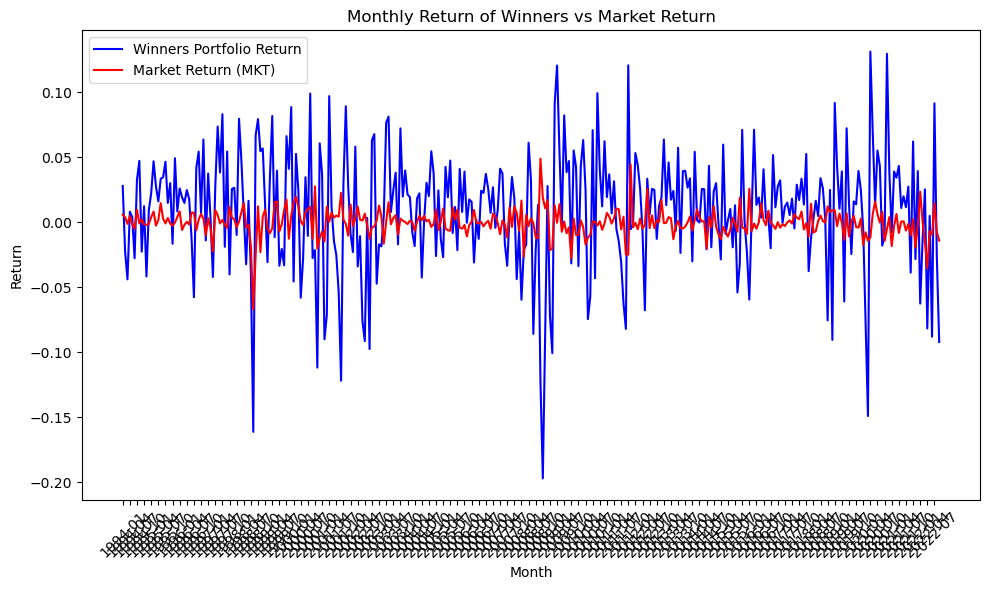

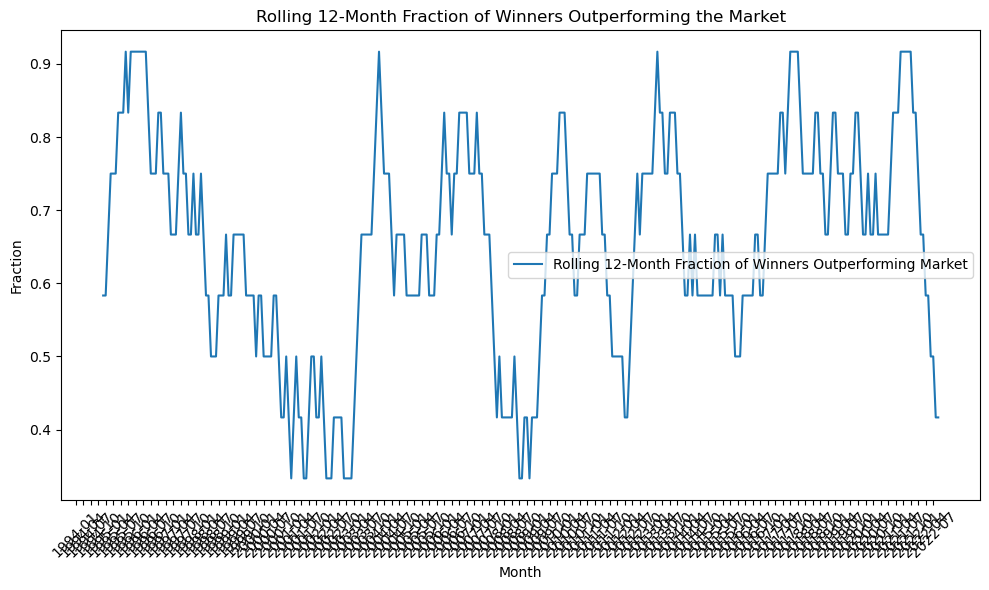

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

momentum_data['date'] = pd.to_datetime(momentum_data['date'], errors='coerce')
momentum_data = pd.merge(momentum_data, ff_factors[['date', 'mkt_rf']], on='date', how='inner')

winners = momentum_data[momentum_data['mcap_bin'] == 10] 

monthly_winners = winners.groupby(winners['date'].dt.to_period('M'))['ret'].mean()

monthly_market_return = momentum_data.groupby(momentum_data['date'].dt.to_period('M'))['mkt_rf'].mean()

overperforming_winners_ratio = (monthly_winners > monthly_market_return).mean()

print(f"Fraction of winners outperforming the market: {overperforming_winners_ratio}")

plt.figure(figsize=(10, 6))
plt.plot(monthly_winners.index.astype(str), monthly_winners, label='Winners Portfolio Return', color='blue')
plt.plot(monthly_market_return.index.astype(str), monthly_market_return, label='Market Return (MKT)', color='red')
plt.title('Monthly Return of Winners vs Market Return')
plt.xlabel('Month')
plt.ylabel('Return')
plt.legend(loc='best')

plt.xticks(ticks=monthly_winners.index[::3].astype(str), rotation=45)

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
overperforming_winners_ratio_monthly = (monthly_winners > monthly_market_return).rolling(window=12).mean()  # 12个月滚动平均
plt.plot(overperforming_winners_ratio_monthly.index.astype(str), overperforming_winners_ratio_monthly, label='Rolling 12-Month Fraction of Winners Outperforming Market')
plt.title('Rolling 12-Month Fraction of Winners Outperforming the Market')
plt.xlabel('Month')
plt.ylabel('Fraction')
plt.legend(loc='best')

plt.xticks(ticks=overperforming_winners_ratio_monthly.index[::3].astype(str), rotation=45)

plt.tight_layout()
plt.show()

In [31]:
momentum_data = data

Average fraction of winners outperforming the market: 0.5080


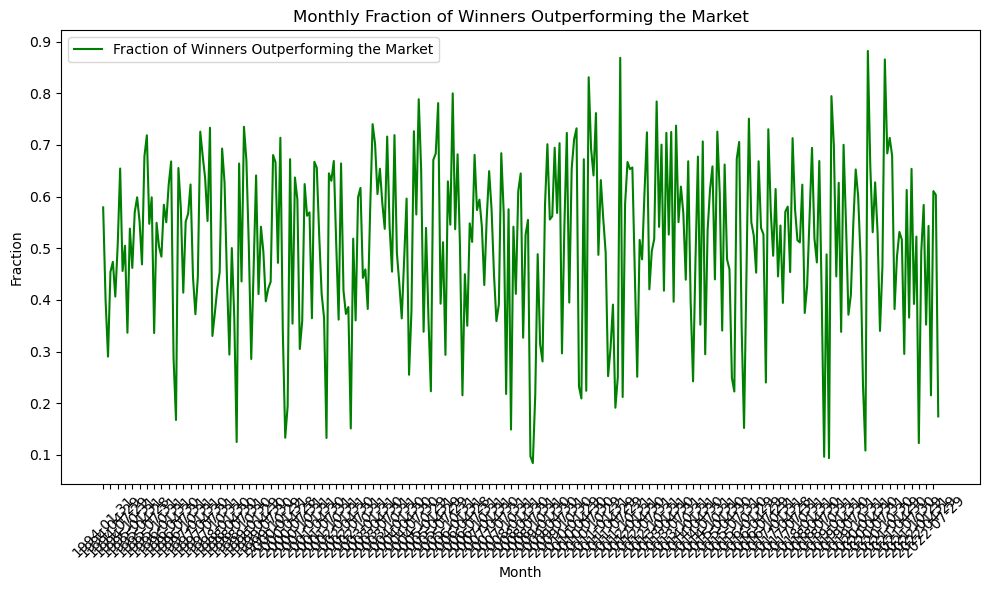

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def compute_winners_fraction(momentum_data, ff_factors):
    momentum_data['date'] = pd.to_datetime(momentum_data['date'])
    ff_factors['date'] = pd.to_datetime(ff_factors['dt'])
    
    momentum_data['quantile'] = momentum_data.groupby('date')['mom'].transform(lambda x: pd.qcut(x, 5, labels=False) + 1)
    
    winners_data = momentum_data[momentum_data['quantile'] == 5]
    
    winners_data = pd.merge(winners_data, ff_factors[['date', 'mkt_rf']], on='date', how='left')

    winners_data['outperform'] = winners_data['ret'] > winners_data['mkt_rf']
    
    monthly_performance = winners_data.groupby('date')['outperform'].mean()
    
    avg_winners_fraction = monthly_performance.mean()
    
    return avg_winners_fraction, monthly_performance

avg_winners_fraction, monthly_performance = compute_winners_fraction(momentum_data, ff_factors)
print(f"Average fraction of winners outperforming the market: {avg_winners_fraction:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(monthly_performance.index.astype(str), monthly_performance, label='Fraction of Winners Outperforming the Market', color='green')
plt.title('Monthly Fraction of Winners Outperforming the Market')
plt.xlabel('Month')
plt.ylabel('Fraction')
plt.legend(loc='best')

plt.xticks(ticks=monthly_performance.index[::3].astype(str), rotation=45)

plt.tight_layout()
plt.show()


In [35]:
momentum_data = data

Average fraction of winners outperforming the market: 0.4672


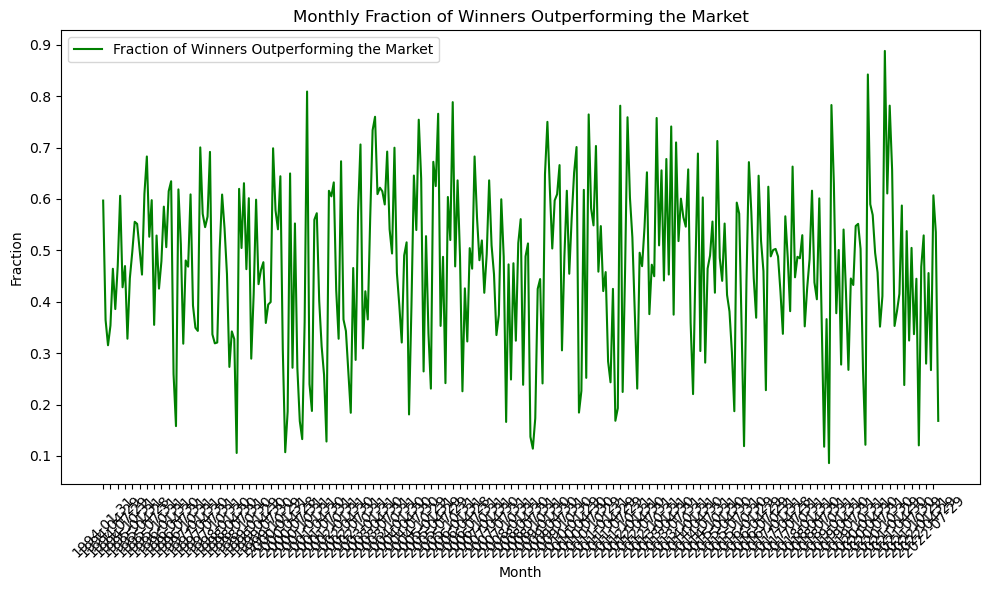

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def compute_winners_fraction(momentum_data, ff_factors):
    momentum_data['date'] = pd.to_datetime(momentum_data['date'])
    ff_factors['date'] = pd.to_datetime(ff_factors['dt'])
    
    momentum_data['quantile'] = momentum_data.groupby('date')['mom_overnight'].transform(lambda x: pd.qcut(x, 5, labels=False) + 1)
    
    winners_data = momentum_data[momentum_data['quantile'] == 5]
    
    winners_data = pd.merge(winners_data, ff_factors[['date', 'mkt_rf']], on='date', how='left')

    winners_data['outperform'] = winners_data['ret'] > winners_data['mkt_rf']
    
    monthly_performance = winners_data.groupby('date')['outperform'].mean()
    
    avg_winners_fraction = monthly_performance.mean()
    
    return avg_winners_fraction, monthly_performance

avg_winners_fraction, monthly_performance = compute_winners_fraction(momentum_data, ff_factors)
print(f"Average fraction of winners outperforming the market: {avg_winners_fraction:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(monthly_performance.index.astype(str), monthly_performance, label='Fraction of Winners Outperforming the Market', color='green')
plt.title('Monthly Fraction of Winners Outperforming the Market')
plt.xlabel('Month')
plt.ylabel('Fraction')
plt.legend(loc='best')

plt.xticks(ticks=monthly_performance.index[::3].astype(str), rotation=45)

plt.tight_layout()
plt.show()

In [39]:
momentum_data = data

Average fraction of winners outperforming the market: 0.5024


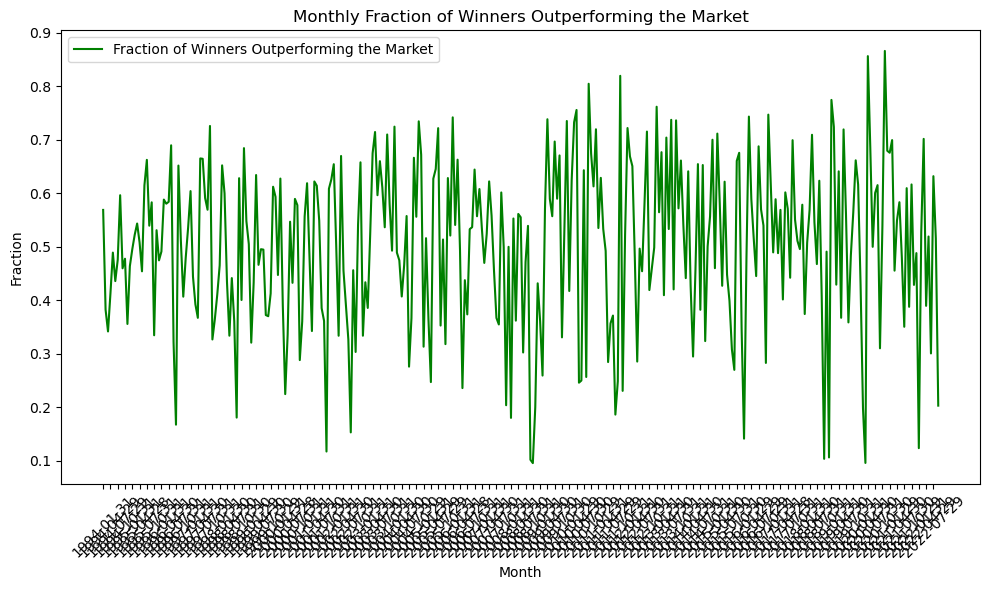

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def compute_winners_fraction(momentum_data, ff_factors):
    momentum_data['date'] = pd.to_datetime(momentum_data['date'])
    ff_factors['date'] = pd.to_datetime(ff_factors['dt'])
    
    momentum_data['quantile'] = momentum_data.groupby('date')['mom_intraday'].transform(lambda x: pd.qcut(x, 5, labels=False) + 1)
    
    winners_data = momentum_data[momentum_data['quantile'] == 5]
    
    winners_data = pd.merge(winners_data, ff_factors[['date', 'mkt_rf']], on='date', how='left')

    winners_data['outperform'] = winners_data['ret'] > winners_data['mkt_rf']
    
    monthly_performance = winners_data.groupby('date')['outperform'].mean()
    
    avg_winners_fraction = monthly_performance.mean()
    
    return avg_winners_fraction, monthly_performance

avg_winners_fraction, monthly_performance = compute_winners_fraction(momentum_data, ff_factors)
print(f"Average fraction of winners outperforming the market: {avg_winners_fraction:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(monthly_performance.index.astype(str), monthly_performance, label='Fraction of Winners Outperforming the Market', color='green')
plt.title('Monthly Fraction of Winners Outperforming the Market')
plt.xlabel('Month')
plt.ylabel('Fraction')
plt.legend(loc='best')

plt.xticks(ticks=monthly_performance.index[::3].astype(str), rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
### total

In [43]:
momentum_data = data

In [45]:
import pandas as pd

def compute_winners_fraction(momentum_data, ff_factors):
    momentum_data['date'] = pd.to_datetime(momentum_data['date'])
    ff_factors['date'] = pd.to_datetime(ff_factors['dt'])

    momentum_data['quantile'] = momentum_data.groupby('date')['mom'].transform(lambda x: pd.qcut(x, 5, labels=False) + 1)
    winners_data = momentum_data[momentum_data['quantile'] == 5]
    winners_data = pd.merge(winners_data, ff_factors[['date', 'mkt_rf']], on='date', how='left')
    
    winners_data['outperform'] = winners_data['ret'] > winners_data['mkt_rf']
    
    monthly_performance = winners_data.groupby('date')['outperform'].mean()
    
    avg_winners_fraction = monthly_performance.mean()
    
    return avg_winners_fraction

avg_winners_fraction = compute_winners_fraction(momentum_data, ff_factors)
print(f"Average fraction of winners outperforming the market: {avg_winners_fraction:.4f}")

Average fraction of winners outperforming the market: 0.5080


In [ ]:
#### Q5: Now compute an “independent sort”, whereby we sort independently on intraday momentum, overnight momentum.

In [62]:
momentum_data = data
momentum_data = momentum_data.dropna()

C:\Users\dell\AppData\Local\Temp\ipykernel_18172\608104937.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  momentum_data['date'] = pd.to_datetime(momentum_data['date'])
C:\Users\dell\AppData\Local\Temp\ipykernel_18172\608104937.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  momentum_data['intraday_bin'] = momentum_data.groupby('date')['mom_intraday'].transform(
C:\Users\dell\AppData\Local\Temp\ipykernel_18172\608104937.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

Equal-Weighted Grid:
[[0.01842432 0.00946273 0.00822054 0.00746    0.00748403]
 [0.01372089 0.00889902 0.0100261  0.01086864 0.01211343]
 [0.00741369 0.00989083 0.01065737 0.01158667 0.01285095]
 [0.00870969 0.01055031 0.01088544 0.0119006  0.01424859]
 [0.01041925 0.01211234 0.01353498 0.01594705 0.01801702]]
Value-Weighted Grid:
[[0.00506386 0.00149319 0.00302664 0.00865016 0.00392701]
 [0.00766809 0.00729332 0.00720535 0.00752434 0.00939065]
 [0.00611668 0.00771074 0.00949113 0.0098527  0.00783626]
 [0.00733635 0.00897012 0.00782153 0.009298   0.01617532]
 [0.00816654 0.00756099 0.00970988 0.01305918 0.01981772]]


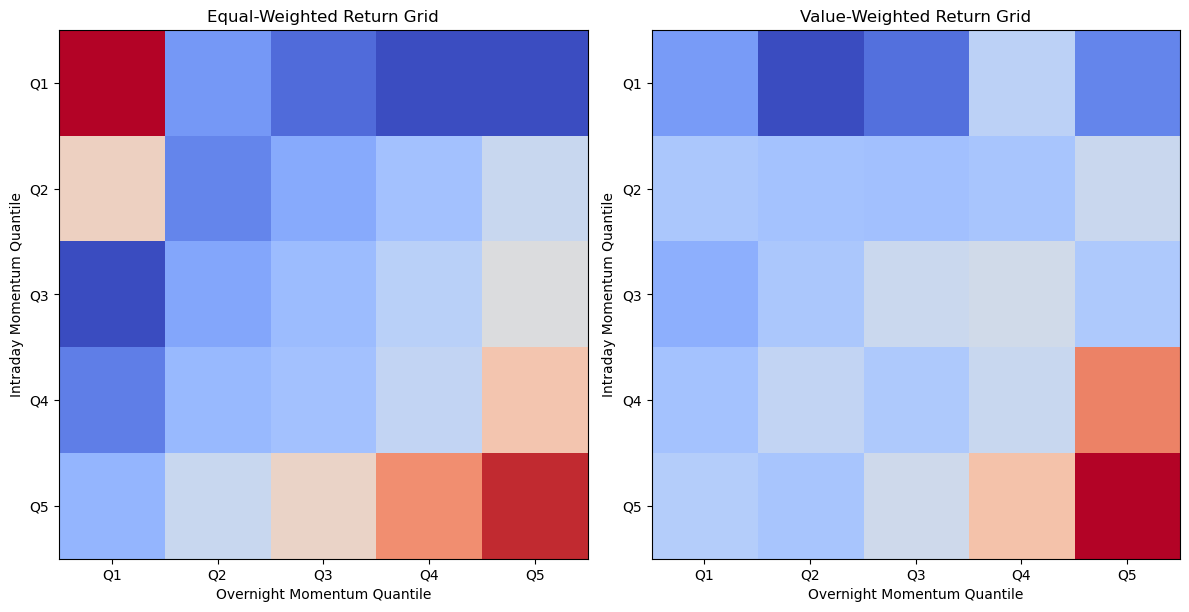

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def independent_sort(momentum_data):
    momentum_data['date'] = pd.to_datetime(momentum_data['date'])
    
    momentum_data['intraday_bin'] = momentum_data.groupby('date')['mom_intraday'].transform(
        lambda x: pd.qcut(x, 5, labels=False, duplicates='drop') + 1)
    momentum_data['overnight_bin'] = momentum_data.groupby('date')['mom_overnight'].transform(
        lambda x: pd.qcut(x, 5, labels=False, duplicates='drop') + 1)  
    
    ew_grid = np.zeros((5, 5))
    vw_grid = np.zeros((5, 5)) 
    
    for date, group in momentum_data.groupby('date'):
        for i in range(1, 6):
            for j in range(1, 6): 
                current_bin = group[(group['intraday_bin'] == i) & (group['overnight_bin'] == j)]
        
                ew_return = current_bin['ret'].mean()
                vw_return = np.average(current_bin['ret'], weights=current_bin['mcap_lag1'])
                
                ew_grid[i-1, j-1] += ew_return
                vw_grid[i-1, j-1] += vw_return
    
    num_months = len(momentum_data['date'].unique())
    ew_grid /= num_months
    vw_grid /= num_months
    
    return ew_grid, vw_grid

ew_grid, vw_grid = independent_sort(momentum_data)
print("Equal-Weighted Grid:")
print(ew_grid)

print("Value-Weighted Grid:")
print(vw_grid)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(ew_grid, cmap='coolwarm', interpolation='nearest')
ax[0].set_title('Equal-Weighted Return Grid')
ax[0].set_xticks(np.arange(5))
ax[0].set_yticks(np.arange(5))
ax[0].set_xticklabels(['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])
ax[0].set_yticklabels(['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])
ax[0].set_xlabel('Overnight Momentum Quantile')
ax[0].set_ylabel('Intraday Momentum Quantile')

ax[1].imshow(vw_grid, cmap='coolwarm', interpolation='nearest')
ax[1].set_title('Value-Weighted Return Grid')
ax[1].set_xticks(np.arange(5))
ax[1].set_yticks(np.arange(5))
ax[1].set_xticklabels(['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])
ax[1].set_yticklabels(['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])
ax[1].set_xlabel('Overnight Momentum Quantile')
ax[1].set_ylabel('Intraday Momentum Quantile')

plt.tight_layout()
plt.show()


In [ ]:
### Q6:maybe some influence

In [78]:
def analyze_momentum_explanations(momentum_data):
    overnight_groups = momentum_data.groupby('overnight_bin')
    intraday_explains_overnight = {}
    for overnight_bin, group in overnight_groups:
        avg_return_by_intraday = group.groupby('intraday_bin')['ret'].mean()
        intraday_explains_overnight[overnight_bin] = avg_return_by_intraday
    
    intraday_groups = momentum_data.groupby('intraday_bin')
    overnight_explains_intraday = {}
    for intraday_bin, group in intraday_groups:
        avg_return_by_overnight = group.groupby('overnight_bin')['ret'].mean()
        overnight_explains_intraday[intraday_bin] = avg_return_by_overnight
    
    combined_grid = np.zeros((5, 5))
    for i in range(1, 6):
        for j in range(1, 6):
            group = momentum_data[(momentum_data['intraday_bin'] == i) & (momentum_data['overnight_bin'] == j)]
            combined_grid[i-1, j-1] = group['ret'].mean()
 
    return {
        'intraday_explains_overnight': intraday_explains_overnight,
        'overnight_explains_intraday': overnight_explains_intraday,
        'combined_grid': combined_grid
    }



In [80]:
analysis_results = analyze_momentum_explanations(momentum_data)
print(analysis_results)

{'intraday_explains_overnight': {1: intraday_bin
1    0.013234
2    0.011212
3    0.007054
4    0.009087
5    0.011425
Name: ret, dtype: float64, 2: intraday_bin
1    0.009761
2    0.009958
3    0.009720
4    0.010871
5    0.012300
Name: ret, dtype: float64, 3: intraday_bin
1    0.008305
2    0.010422
3    0.010975
4    0.010804
5    0.012992
Name: ret, dtype: float64, 4: intraday_bin
1    0.007641
2    0.011038
3    0.012073
4    0.011806
5    0.013283
Name: ret, dtype: float64, 5: intraday_bin
1    0.008055
2    0.012455
3    0.011423
4    0.014215
5    0.014650
Name: ret, dtype: float64}, 'overnight_explains_intraday': {1: overnight_bin
1    0.013234
2    0.009761
3    0.008305
4    0.007641
5    0.008055
Name: ret, dtype: float64, 2: overnight_bin
1    0.011212
2    0.009958
3    0.010422
4    0.011038
5    0.012455
Name: ret, dtype: float64, 3: overnight_bin
1    0.007054
2    0.009720
3    0.010975
4    0.012073
5    0.011423
Name: ret, dtype: float64, 4: overnight_bin
1    0.009

In [68]:
import statsmodels.api as sm

for overnight_bin in range(1, 6):
    subset = momentum_data[momentum_data['overnight_bin'] == overnight_bin]
    X = subset['mom_intraday']  # intraday momentum
    X = sm.add_constant(X) 
    y = subset['ret']
    
    model = sm.OLS(y, X).fit()
    print(f"Overnight bin {overnight_bin} - Intraday momentum regression:")
    print(model.summary())


Overnight bin 1 - Intraday momentum regression:
                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.943
Date:                Thu, 27 Feb 2025   Prob (F-statistic):              0.163
Time:                        20:36:49   Log-Likelihood:                 33163.
No. Observations:              330543   AIC:                        -6.632e+04
Df Residuals:                  330541   BIC:                        -6.630e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------


In [70]:
for intraday_bin in range(1, 6):
    subset = momentum_data[momentum_data['intraday_bin'] == intraday_bin]
    X = subset['mom_overnight']  # overnight momentum
    X = sm.add_constant(X)  
    y = subset['ret'] 
    
    model = sm.OLS(y, X).fit()
    print(f"Intraday bin {intraday_bin} - Overnight momentum regression:")
    print(model.summary())


Intraday bin 1 - Overnight momentum regression:
                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     5.369
Date:                Thu, 27 Feb 2025   Prob (F-statistic):             0.0205
Time:                        20:36:55   Log-Likelihood:                -61222.
No. Observations:              330543   AIC:                         1.224e+05
Df Residuals:                  330541   BIC:                         1.225e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

In [ ]:
### Q7: Does the strategy which shorts stocks which are low quintile of both momentum 
### strategies, and long the high quintile of both momentum strategies (i.e. long the boWom 
### right corner, short the top lem corner), perform well?

In [72]:
long_subset = momentum_data[(momentum_data['intraday_bin'] == 5) & (momentum_data['overnight_bin'] == 5)]
short_subset = momentum_data[(momentum_data['intraday_bin'] == 1) & (momentum_data['overnight_bin'] == 1)]

long_return = long_subset['ret'].mean()
short_return = short_subset['ret'].mean()
strategy_return = long_return - short_return
print(f"Long-Short Strategy Return Sum: {strategy_return}")

Long-Short Strategy Return Sum: 0.0014161174338927114


C:\Users\dell\AppData\Local\Temp\ipykernel_18172\1291068100.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_momentum_stocks['date'] = pd.to_datetime(high_momentum_stocks['date'])
C:\Users\dell\AppData\Local\Temp\ipykernel_18172\1291068100.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_momentum_stocks['date'] = pd.to_datetime(low_momentum_stocks['date'])
C:\Users\dell\AppData\Local\Temp\ipykernel_18172\1291068100.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping col

Sharpe Ratio for Strategy 1 (EW): -0.0041
Sharpe Ratio for Strategy 1 (VW): 0.8087
Sharpe Ratio for Custom Strategy (EW): 0.0561
Sharpe Ratio for Custom Strategy (VW): nan


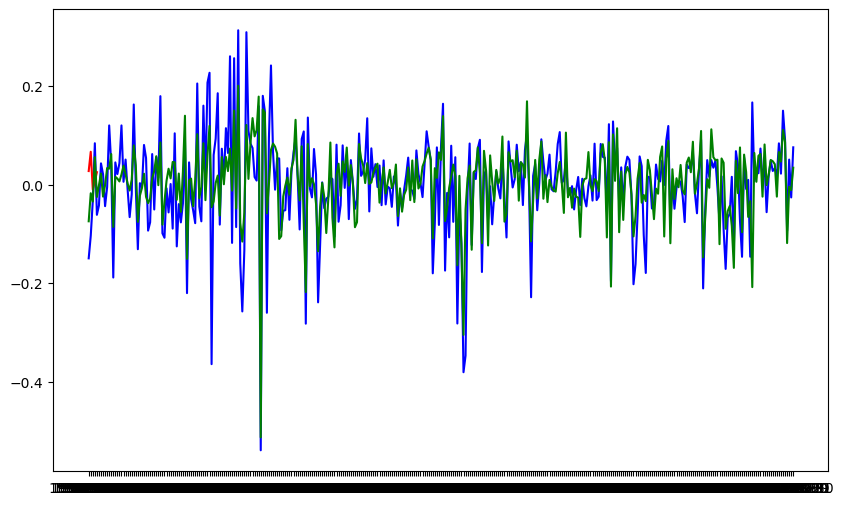

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

high_momentum_stocks = momentum_data[(momentum_data['intraday_bin'] == 5) & (momentum_data['overnight_bin'] == 5)]  
low_momentum_stocks = momentum_data[(momentum_data['intraday_bin'] == 1) & (momentum_data['overnight_bin'] == 1)]

high_momentum_stocks['date'] = pd.to_datetime(high_momentum_stocks['date'])
low_momentum_stocks['date'] = pd.to_datetime(low_momentum_stocks['date'])

high_momentum_stocks_monthly = high_momentum_stocks.groupby(['date', 'permno'])['ret'].mean().reset_index()
low_momentum_stocks_monthly = low_momentum_stocks.groupby(['date', 'permno'])['ret'].mean().reset_index()

high_momentum_stocks_monthly = pd.merge(high_momentum_stocks_monthly, high_momentum_stocks[['date', 'permno', 'mcap_lag1']], on=['date', 'permno'])
low_momentum_stocks_monthly = pd.merge(low_momentum_stocks_monthly, low_momentum_stocks[['date', 'permno', 'mcap_lag1']], on=['date', 'permno'])

high_momentum_stocks_monthly['ew_return'] = high_momentum_stocks_monthly.groupby('date')['ret'].transform('mean')
high_momentum_stocks_monthly['vw_return'] = high_momentum_stocks_monthly.groupby('date').apply(
    lambda group: np.average(group['ret'], weights=group['mcap_lag1'])
).reset_index(level=0, drop=True)

low_momentum_stocks_monthly['ew_return'] = low_momentum_stocks_monthly.groupby('date')['ret'].transform('mean')
low_momentum_stocks_monthly['vw_return'] = low_momentum_stocks_monthly.groupby('date').apply(
    lambda group: np.average(group['ret'], weights=group['mcap_lag1'])
).reset_index(level=0, drop=True)


strategy_data_1 = pd.merge(high_momentum_stocks_monthly[['date', 'permno', 'ew_return', 'vw_return']],
                           low_momentum_stocks_monthly[['date', 'permno', 'ew_return', 'vw_return']],
                           on=['date'], suffixes=('_long', '_short'))

strategy_data_1['strategy_ew_return'] = strategy_data_1['ew_return_long'] - strategy_data_1['ew_return_short']
strategy_data_1['strategy_vw_return'] = strategy_data_1['vw_return_long'] - strategy_data_1['vw_return_short']






momentum_data['mom_bucket'] = pd.qcut(momentum_data['mom_intraday'] + momentum_data['mom_overnight'], 10, labels=False) + 1
momentum_data = momentum_data.dropna()
high_momentum_custom = momentum_data[momentum_data['mom_bucket'] == 10]
low_momentum_custom = momentum_data[momentum_data['mom_bucket'] == 1]

high_momentum_custom_monthly = high_momentum_custom.groupby(['date', 'permno'])['ret'].mean().reset_index()
low_momentum_custom_monthly = low_momentum_custom.groupby(['date', 'permno'])['ret'].mean().reset_index()

high_momentum_custom_monthly = pd.merge(high_momentum_custom_monthly, high_momentum_custom[['date', 'permno', 'mcap_lag1']], on=['date', 'permno'])
low_momentum_custom_monthly = pd.merge(low_momentum_custom_monthly, low_momentum_custom[['date', 'permno', 'mcap_lag1']], on=['date', 'permno'])

high_momentum_custom_monthly['ew_return'] = high_momentum_custom_monthly.groupby('date')['ret'].transform('mean')
high_momentum_custom_monthly['vw_return'] = high_momentum_custom_monthly.groupby('date').apply(
    lambda group: np.average(group['ret'], weights=group['mcap_lag1'])
).reset_index(level=0, drop=True)

low_momentum_custom_monthly['ew_return'] = low_momentum_custom_monthly.groupby('date')['ret'].transform('mean')
low_momentum_custom_monthly['vw_return'] = low_momentum_custom_monthly.groupby('date').apply(
    lambda group: np.average(group['ret'], weights=group['mcap_lag1'])
).reset_index(level=0, drop=True)

custom_strategy_data = pd.merge(high_momentum_custom_monthly[['date', 'ew_return', 'vw_return']],
                                low_momentum_custom_monthly[['date', 'ew_return', 'vw_return']],
                                on=['date'], suffixes=('_long', '_short'))

custom_strategy_data['strategy_ew_return'] = custom_strategy_data['ew_return_long'] - custom_strategy_data['ew_return_short']
custom_strategy_data['strategy_vw_return'] = custom_strategy_data['vw_return_long'] - custom_strategy_data['vw_return_short']





monthly_strategy_ew_return_1 = strategy_data_1.groupby('date')['strategy_ew_return'].mean()
monthly_strategy_vw_return_1 = strategy_data_1.groupby('date')['strategy_vw_return'].mean()

monthly_strategy_ew_return_custom = custom_strategy_data.groupby('date')['strategy_ew_return'].mean()
monthly_strategy_vw_return_custom = custom_strategy_data.groupby('date')['strategy_vw_return'].mean()





def compute_sharpe_ratio(strategy_return):
    excess_return = strategy_return.mean()
    volatility = strategy_return.std()
    return excess_return / volatility

sharpe_ew_1 = compute_sharpe_ratio(monthly_strategy_ew_return_1)
sharpe_vw_1 = compute_sharpe_ratio(monthly_strategy_vw_return_1)

sharpe_ew_custom = compute_sharpe_ratio(monthly_strategy_ew_return_custom)
sharpe_vw_custom = compute_sharpe_ratio(monthly_strategy_vw_return_custom)

print(f"Sharpe Ratio for Strategy 1 (EW): {sharpe_ew_1:.4f}")
print(f"Sharpe Ratio for Strategy 1 (VW): {sharpe_vw_1:.4f}")
print(f"Sharpe Ratio for Custom Strategy (EW): {sharpe_ew_custom:.4f}")
print(f"Sharpe Ratio for Custom Strategy (VW): {sharpe_vw_custom:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(monthly_strategy_ew_return_1.index.astype(str), monthly_strategy_ew_return_1, label='Strategy 1 EW Return', color='blue')
plt.plot(monthly_strategy_vw_return_1.index.astype(str), monthly_strategy_vw_return_1, label='Strategy 1 VW Return', color='red')
plt.plot(monthly_strategy_ew_return_custom.index.astype(str), monthly_strategy_ew_return_custom, label='Custom Strategy EW Return', color='green')
plt.plot(monthly_strategy_vw_return_custom.index.astype(str), monthly_strategy_vw_return_custom, label='Custom Strategy VW Return', color='red')


In [ ]:
### long short stategy total

         Month  Long_Short_Return  Cumulative_Return
0   1994-01-01          -0.149776          -0.149776
1   1994-02-01          -0.104191          -0.238362
2   1994-03-01          -0.032752          -0.263307
3   1994-04-01           0.083852          -0.201534
4   1994-05-01          -0.061411          -0.250568
..         ...                ...                ...
340 2022-05-01           0.090632          -0.871241
341 2022-06-01          -0.094036          -0.883349
342 2022-07-01           0.050691          -0.877435
343 2022-08-01          -0.026135          -0.880639
344 2022-09-01           0.075556          -0.871620

[345 rows x 3 columns]


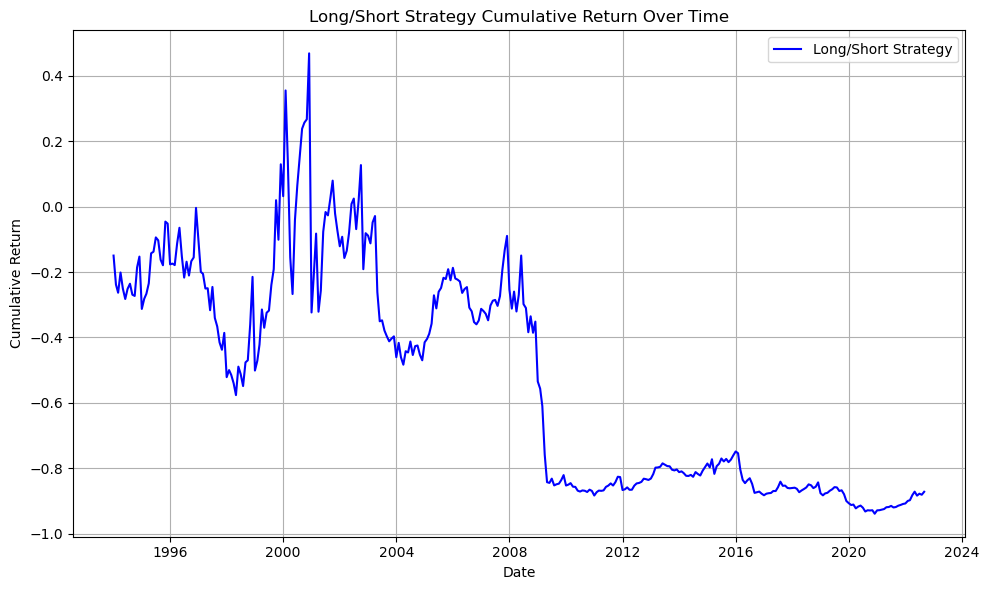

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def long_short_strategy_time_series(momentum_data):
    momentum_data['date'] = pd.to_datetime(momentum_data['date'])
    long_short_returns = []
    
    for month, group in momentum_data.groupby(momentum_data['date'].dt.to_period('M')):
        long_stocks = group[(group['intraday_bin'] == 5) & (group['overnight_bin'] == 5)]
        short_stocks = group[(group['intraday_bin'] == 1) & (group['overnight_bin'] == 1)]
        
        long_return = long_stocks['ret'].mean() if len(long_stocks) > 0 else 0
        short_return = short_stocks['ret'].mean() if len(short_stocks) > 0 else 0
        
        long_short_return = long_return - short_return
        long_short_returns.append((month, long_short_return))
    
    long_short_df = pd.DataFrame(long_short_returns, columns=['Month', 'Long_Short_Return'])
    long_short_df['Month'] = long_short_df['Month'].dt.to_timestamp()  # 转换回Timestamp以便绘图
    
    long_short_df['Cumulative_Return'] = (1 + long_short_df['Long_Short_Return']).cumprod() - 1
    
    return long_short_df

long_short_result = long_short_strategy_time_series(momentum_data)

print(long_short_result)

plt.figure(figsize=(10, 6))
plt.plot(long_short_result['Month'], long_short_result['Cumulative_Return'], label='Long/Short Strategy', color='b')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Long/Short Strategy Cumulative Return Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [84]:
import numpy as np
import pandas as pd

def compute_sharpe_ratio(returns):
    return np.mean(returns) / np.std(returns) if np.std(returns) != 0 else 0

def calculate_sharpe(momentum_data):
    ew_grid, vw_grid = independent_sort(momentum_data)
    
    ew_monthly_returns = ew_grid.mean(axis=0)
    vw_monthly_returns = vw_grid.mean(axis=0)
    
    ew_sharpe = compute_sharpe_ratio(ew_monthly_returns)
    vw_sharpe = compute_sharpe_ratio(vw_monthly_returns)
    
    return ew_sharpe, vw_sharpe


ew_sharpe, vw_sharpe = calculate_sharpe(momentum_data)

print(f"Equal-weighted strategy Sharpe Ratio: {ew_sharpe}")
print(f"Value-weighted strategy Sharpe Ratio: {vw_sharpe}")

Equal-weighted strategy Sharpe Ratio: 11.983832767279912
Value-weighted strategy Sharpe Ratio: 4.523648377115263


In [86]:
def long_short_custom_factor(momentum_data):
    long_stocks = momentum_data[(momentum_data['intraday_bin'] == 5) & (momentum_data['overnight_bin'] == 5)]
    short_stocks = momentum_data[(momentum_data['intraday_bin'] == 1) & (momentum_data['overnight_bin'] == 1)]
    
    long_return = long_stocks['ret'].mean() if len(long_stocks) > 0 else 0
    short_return = short_stocks['ret'].mean() if len(short_stocks) > 0 else 0
    
    long_short_return = long_return - short_return
    return long_short_return

def custom_factor_sharpe(momentum_data):
    custom_returns = []
    for month, group in momentum_data.groupby(momentum_data['date'].dt.to_period('M')):
        long_short_return = long_short_custom_factor(group)
        custom_returns.append(long_short_return)
    
    return compute_sharpe_ratio(custom_returns)

custom_sharpe = custom_factor_sharpe(momentum_data)

print(f"Custom long-short factor Sharpe Ratio: {custom_sharpe}")

Custom long-short factor Sharpe Ratio: -0.004068079536080721


In [ ]:
### Q8: 

In [76]:
import statsmodels.api as sm
import pandas as pd

# Step 1: Fama-MacBeth：overnight return -> future return
fama_macbeth_results = []

for date in momentum_data['date'].unique():
    subset = momentum_data[momentum_data['date'] == date]
    X = subset['overnight_ret_month']
    X = sm.add_constant(X)
    y = subset['ret']  # future returns
    
    model = sm.OLS(y, X).fit()
    fama_macbeth_results.append(model.params)

fama_macbeth_coefficients = pd.DataFrame(fama_macbeth_results)
fama_macbeth_avg = fama_macbeth_coefficients.mean()
fama_macbeth_t_stats = fama_macbeth_coefficients / fama_macbeth_coefficients.std()


# Step 2: Fama-MacBeth cross-section：intraday momentum -> return
cross_sectional_results = []

for date in momentum_data['date'].unique():
    subset = momentum_data[momentum_data['date'] == date]
    X = subset['mom_intraday']
    X = sm.add_constant(X)
    y = subset['ret']  # returns
    
    model = sm.OLS(y, X).fit()
    cross_sectional_results.append(model.params)

cross_sectional_coefficients = pd.DataFrame(cross_sectional_results)
cross_sectional_avg = cross_sectional_coefficients.mean()
cross_sectional_t_stats = cross_sectional_coefficients / cross_sectional_coefficients.std()

# Step 3: Interaction：overnight momentum * intraday momentum -> return
interaction_results = []

for date in momentum_data['date'].unique():
    subset = momentum_data[momentum_data['date'] == date]
    X = subset[['mom_intraday', 'mom_overnight']]
    X['interaction'] = X['mom_intraday'] * X['mom_overnight']  # 创建交互项
    X = sm.add_constant(X)
    y = subset['ret']  # returns
    
    model = sm.OLS(y, X).fit()
    interaction_results.append(model.params)  # 存储回归结果

interaction_coefficients = pd.DataFrame(interaction_results)
interaction_avg = interaction_coefficients.mean()
interaction_t_stats = interaction_coefficients / interaction_coefficients.std()

print("Fama-MacBeth Regression: \n", fama_macbeth_avg, fama_macbeth_t_stats)
print("Fama-MacBeth Cross-Sectional Regression: \n", cross_sectional_avg, cross_sectional_t_stats)
print("Interaction: \n", interaction_avg, interaction_t_stats)

C:\Users\dell\AppData\Local\Temp\ipykernel_18172\2544774856.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['interaction'] = X['mom_intraday'] * X['mom_overnight']  # 创建交互项
C:\Users\dell\AppData\Local\Temp\ipykernel_18172\2544774856.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['interaction'] = X['mom_intraday'] * X['mom_overnight']  # 创建交互项
C:\Users\dell\AppData\Local\Temp\ipykernel_18172\2544774856.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

Fama-MacBeth Regression: 
 const                  0.003410
overnight_ret_month    0.320735
dtype: float64         const  overnight_ret_month
0    0.897712             0.556076
1   -0.119647             0.004032
2   -0.811608             0.125896
3   -0.285480             0.293241
4   -0.043776             0.055844
..        ...                  ...
340 -0.511799             0.922349
341 -1.105005             1.739857
342  1.480425             1.436861
343 -0.112595             2.138170
344 -1.788157             0.651695

[345 rows x 2 columns]
Fama-MacBeth Cross-Sectional Regression: 
 const           0.009753
mom_intraday    0.003402
dtype: float64         const  mom_intraday
0    0.879005     -0.032727
1   -0.131811      0.300335
2   -0.793307      0.273475
3   -0.290913      0.646979
4   -0.035083     -0.193614
..        ...           ...
340 -0.243724      1.430764
341 -1.359449     -0.827949
342  1.356069     -0.326924
343 -0.130359     -0.580021
344 -1.641001      1.677897

[345 

C:\Users\dell\AppData\Local\Temp\ipykernel_18172\2544774856.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['interaction'] = X['mom_intraday'] * X['mom_overnight']  # 创建交互项
C:\Users\dell\AppData\Local\Temp\ipykernel_18172\2544774856.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['interaction'] = X['mom_intraday'] * X['mom_overnight']  # 创建交互项
C:\Users\dell\AppData\Local\Temp\ipykernel_18172\2544774856.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

In [88]:
import statsmodels.api as sm
import pandas as pd

momentum_data['date'] = pd.to_datetime(momentum_data['date'], errors='coerce')

long_stocks = momentum_data[(momentum_data['intraday_bin'] == 5) & (momentum_data['overnight_bin'] == 5)]
short_stocks = momentum_data[(momentum_data['intraday_bin'] == 1) & (momentum_data['overnight_bin'] == 1)]

momentum_portfolio_return = long_stocks['ret'].mean() - short_stocks['ret'].mean()

momentum_data['momentum_return'] = momentum_data.apply(
    lambda x: (x['ret'] if x['intraday_bin'] == 5 and x['overnight_bin'] == 5 else 
               (-x['ret']) if x['intraday_bin'] == 1 and x['overnight_bin'] == 1 else 0), 
    axis=1
)

merged_data = pd.merge(momentum_data, ff_factors, on='date', how='inner')



X_momentum = merged_data[['momentum_return']] 
X_momentum = sm.add_constant(X_momentum)
y = merged_data['ret'] 

model_momentum = sm.OLS(y, X_momentum).fit()



X_ff5 = merged_data[['momentum_return', 'mkt_rf', 'smb', 'hml', 'rmw', 'cma']] 
X_ff5 = sm.add_constant(X_ff5) 
model_ff5 = sm.OLS(y, X_ff5).fit()

print("Mom Alpha:")
print(model_momentum.summary())

print("\nMom + FF5 Factors Alpha:")
print(model_ff5.summary())

Mom Alpha:
                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                 1.158e+04
Date:                Thu, 27 Feb 2025   Prob (F-statistic):               0.00
Time:                        20:47:08   Log-Likelihood:             3.5352e+05
No. Observations:             1652032   AIC:                        -7.070e+05
Df Residuals:                 1652030   BIC:                        -7.070e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0106     

In [90]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

### Fama-Mecbeth
def fama_macbeth_regression(data, X_columns, y_column):
    coefficients = []
    t_statistics = []
    
    for date, group in data.groupby('date'):
        X = group[X_columns]
        X = sm.add_constant(X) 
        y = group[y_column]
        
        model = sm.OLS(y, X).fit()
        
        coefficients.append(model.params)
        t_statistics.append(model.tvalues)
    
    coeff_df = pd.DataFrame(coefficients, columns=X_columns + ['const'])
    t_stat_df = pd.DataFrame(t_statistics, columns=X_columns + ['const'])
    
    mean_coeffs = coeff_df.mean()
    se_coeffs = coeff_df.std() / np.sqrt(len(coeff_df))
    
    mean_tstats = t_stat_df.mean()
    se_tstats = t_stat_df.std() / np.sqrt(len(t_stat_df))
    
    return mean_coeffs, se_coeffs, mean_tstats, se_tstats

merged_data['future_return'] = merged_data['ret'].shift(-1)  

# 1. Overnight return and future return
X_overnight = ['overnight_ret_month']  
y = 'future_return'  
mean_coeffs_overnight, se_coeffs_overnight, mean_tstats_overnight, se_tstats_overnight = fama_macbeth_regression(
    merged_data, X_overnight, y
)

# 2. Intraday momentum and future return
X_intraday = ['mom_intraday'] 
mean_coeffs_intraday, se_coeffs_intraday, mean_tstats_intraday, se_tstats_intraday = fama_macbeth_regression(
    merged_data, X_intraday, y
)

# 3. Overnight return * Intraday momentum and future return
merged_data['interaction'] = merged_data['overnight_ret_month'] * merged_data['mom_intraday']
X_both = ['overnight_ret_month', 'mom_intraday', 'interaction']  
mean_coeffs_both, se_coeffs_both, mean_tstats_both, se_tstats_both = fama_macbeth_regression(
    merged_data, X_both, y
)

results = pd.DataFrame({
    'Coefficient': pd.concat([mean_coeffs_overnight, mean_coeffs_intraday, mean_coeffs_both]),
    'Standard Error': pd.concat([se_coeffs_overnight, se_coeffs_intraday, se_coeffs_both]),
    't-statistic': pd.concat([mean_tstats_overnight, mean_tstats_intraday, mean_tstats_both]),
})


print(results)

                     Coefficient  Standard Error  t-statistic
overnight_ret_month    -0.004422        0.003647    -0.392262
const                   0.010432        0.003133     2.379654
mom_intraday            0.004179        0.001817     1.396458
const                   0.010075        0.003032     2.346804
overnight_ret_month    -0.000064        0.003524    -0.068090
mom_intraday            0.004241        0.001778     1.293537
interaction            -0.001837        0.003910     0.104513
const                   0.010072        0.002990     2.309970
